In [1]:
import re
import time
import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. Needed to remove SettingWithCopyWarning warning when assigning new value to dataframe column
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly.express as px

import statsmodels.formula.api as smf
import scipy.stats as stats

%load_ext autoreload
%autoreload 2

from housing_crawler.utils import save_file, get_file, crawl_ind_ad_page
from housing_crawler.analysis.ads_table_processing import prepare_data, filter_out_bad_entries, transform_columns_into_numerical, hot_encode_columns, feature_engineering


In [2]:
all_ads = get_file(file_name='all_encoded.csv', local_file_path=f'housing_crawler/data')

df_processed = prepare_data(ads_df = all_ads)
df_processed = filter_out_bad_entries(ads_df = df_processed, country = 'Germany',
                       price_max = 6000, price_min = 50,
                      size_max = 400, size_min = 3,
                      date_max = None, date_min = None, date_format = "%d.%m.%Y")
df_processed = transform_columns_into_numerical(ads_df = df_processed)
# df_processed = hot_encode_columns(ads_df = df_processed)
df_processed = feature_engineering(ads_df = df_processed)

ads_df = df_processed.drop(columns=['details_searched', 'cold_rent_euros',
       'mandatory_costs_euros', 'extra_costs_euros', 'transfer_costs_euros',
       'deposit', 'zip_code', 'home_total_size', 'smoking', 'wg_type',
       'age_range', 'gender_search', 'energy', 'wg_possible', 'building_type',
       'building_floor', 'furniture', 'kitchen', 'shower_type', 'tv',
       'floor_type', 'heating', 'public_transport_distance', 'internet',
       'parking', 'schufa_needed', 'extras_waschmaschine',
       'extras_spuelmaschine', 'extras_terrasse', 'extras_balkon',
       'extras_garten', 'extras_gartenmitbenutzung', 'extras_keller',
       'extras_aufzug', 'extras_haustiere', 'extras_fahrradkeller',
       'extras_dachboden', 'languages_deutsch', 'languages_englisch',
       'number_languages', 'min_age_flatmates', 'max_age_flatmates'])

===> Loaded all_encoded.csv locally


In [3]:
ads_df.head(20)

id                                                url landlord_type  \
0   7100091  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
1   9534584  https://www.wg-gesucht.de/1-zimmer-wohnungen-i...       Private   
2   9534654  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
3   9534629  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
4   4568391  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
5   9532515  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
6   9344285  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
7   9534758  https://www.wg-gesucht.de/wohnungen-in-Berlin-...       Private   
8   9534729  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
9   8244705  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
10  9534703  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
11  9534628  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
12  6526363  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
13  9534792  https://www.wg-gesucht.de/1-zimmer-wohnungen-i...       Private   
14  8154295  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
15  9534813  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
16  9534814  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
17  9535042  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
18  9534756  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   
19  9534875  https://www.wg-gesucht.de/wg-zimmer-in-Berlin-...       Private   

                                                title  price_euros  size_sqm  \
0   01.09. - 22.09.2022 +++ SUBLET - Möbliertes 26...          500        26   
1   Großes möbliertes Zimmer - geselliges Studente...          500        20   
2   Großes  teilmöbliertes Zimmer im schönen Witte...          450        18   
3         Zimmer in Studentenwohnheim Zehlendorf 18qm          540        18   
4                                       Krille‘s Bude          500        25   
5           3 Wochen - Gemütliches Zimmer in Steglitz          400        25   
6                  Room in Adlershof - Long Term only          400        26   
7      Cozy 2-room apartment in Berlin-Friedrichshain         1400        67   
8            Room to subrent (september-october 2022)          600        25   
9     Christliche Studenten-WG Berlin Prenzlauer Berg          350        15   
10                            WG Zimmer im Weissensee          635        20   
11                      WG Zimmer | 30qm | nähe Havel          700        30   
12  Cozy Room in a 80m2 - 2 people Flat w/ living ...          550        17   
13  Komplett möbliert Wohnung für Sep-Oct-Nov in N...          620        32   
14         WG Zimmer in einem Frauengemeinschaftshaus          500        12   
15                       WG Zimmer Available / Sublet          490        11   
16               Sublet in a shared student apartment          490        22   
17        Furnished room for one month (for students)          330        13   
18  Helles Zimmer mit Balkon in Karlshorst in eine...          635        20   
19  SEPTEMBER - WG Zimmer in großzügigem Altbau im...          600        16   

    available_rooms  capacity  available_spots_wg  male_flatmates  ...  \
0               1.0         2                   1               0  ...   
1               1.0         0                   0               0  ...   
2               1.0         5                   2               2  ...   
3               1.0         2                   1               0  ...   
4               1.0         3                   2               0  ...   
5               1.0         4                   1               1  ...   
6               1.0         2                   1               0  ...   
7               2.0         0                   0      

In [4]:
ads_df.columns

Index(['id', 'url', 'landlord_type', 'title', 'price_euros', 'size_sqm',
       'available_rooms', 'capacity', 'available_spots_wg', 'male_flatmates',
       'female_flatmates', 'diverse_flatmates', 'published_on', 'published_at',
       'address', 'city', 'crawler', 'latitude', 'longitude', 'available_from',
       'available_to', 'type_offer_simple', 'day_of_week_publication',
       'price_per_sqm', 'days_available'],
      dtype='object')

In [5]:
typeoffer_ads_df = ads_df[['url', 'type_offer_simple']].groupby('type_offer_simple').count().rename(columns={'url':'count'}).sort_values(by = ['count'], ascending=False)
typeoffer_ads_df

count
type_offer_simple       
WG                 37144
Apartment           6808
Single-room flat    6337
House                107

In [6]:
## Filter type of offer
wg_df = ads_df.query('type_offer_simple == "WG"\
                     & price_euros <= 2000\
                     & price_euros > 100\
                     & size_sqm <= 60\
                     & size_sqm >= 3').reset_index().drop(columns=['index'])

singleroom_df = ads_df.query('type_offer_simple == "Single-room flat"\
                     & price_euros <= 2500\
                     & price_euros > 100\
                     & size_sqm <= 100\
                     & size_sqm >= 10').reset_index().drop(columns=['index'])

flathouse_df = ads_df.query('(type_offer_simple == "Apartment")\
                     & price_euros <= 6000\
                     & price_euros > 100\
                     & size_sqm <= 300\
                     & size_sqm >= 25').reset_index().drop(columns=['index'])

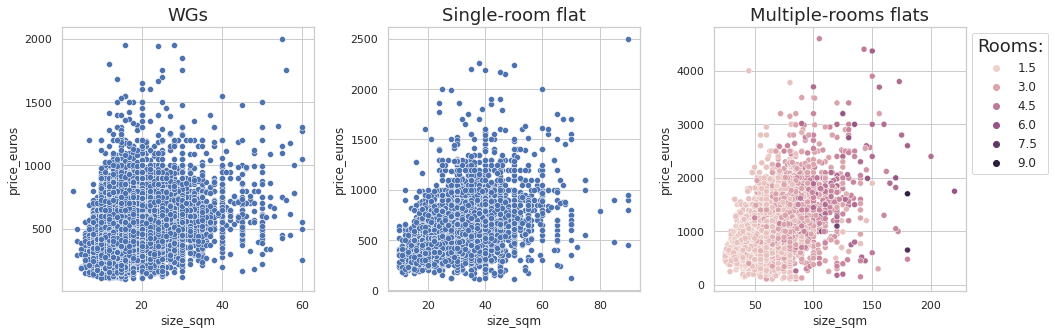

In [7]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.set_theme(style = "whitegrid", font_scale= 1.5)
sns.scatterplot(data = wg_df, y='price_euros',x='size_sqm', ax=ax1).set(title='WGs')
sns.scatterplot(data = singleroom_df, y='price_euros',x='size_sqm', ax=ax2).set(title='Single-room flat')
sns.scatterplot(data = flathouse_df, y='price_euros',x='size_sqm', ax=ax3, hue = 'available_rooms').set(title='Multiple-rooms flats')
ax3.legend(title='Rooms:', fontsize=12, bbox_to_anchor= (1,1))# loc='upper right')
plt.tight_layout();

In [8]:
dayweek_wg_df = wg_df[['url', 'day_of_week_publication']].groupby('day_of_week_publication').count().rename(columns={'url':'count'})
dayweek_wg_df['order'] = [5,1,6,7,4,2,3]
dayweek_wg_df = dayweek_wg_df.sort_values(by = ['order']).drop(['order'], axis=1)
dayweek_wg_df['Percentage'] = dayweek_wg_df['count'].apply(lambda x: round(100*x/sum(dayweek_wg_df['count']),2))
dayweek_wg_df

count  Percentage
day_of_week_publication                   
Mon                       6874       18.57
Tue                       6109       16.50
Wed                       5884       15.89
Thu                       4447       12.01
Fri                       4653       12.57
Sat                       4424       11.95
Sun                       4631       12.51

In [9]:
hourday_wg_df = wg_df[['url', 'published_at']].groupby('published_at').count().rename(columns={'url':'count'})
hourday_wg_df['Percentage'] = hourday_wg_df['count'].apply(lambda x: round(100*x/sum(hourday_wg_df['count']),2))
hourday_wg_df

count  Percentage
published_at                   
0               805        2.89
1               304        1.09
2               147        0.53
3                63        0.23
4                40        0.14
5                44        0.16
6                68        0.24
7               203        0.73
8               541        1.94
9              1016        3.64
10             1329        4.77
11             1744        6.25
12             1907        6.84
13             1933        6.93
14             1909        6.84
15             1866        6.69
16             1953        7.00
17             1858        6.66
18             1960        7.03
19             1832        6.57
20             1742        6.25
21             1748        6.27
22             1649        5.91
23             1229        4.41

In [10]:
city_wg_df = wg_df[['url', 'city']].groupby('city').count().rename(columns={'url':'count'}).sort_values(by = ['count'], ascending=False)
city_wg_df['Percentage'] = city_wg_df['count'].apply(lambda x: round(100*x/sum(city_wg_df['count']),2))
city_wg_df

count  Percentage
city                                
Berlin              5118       13.82
München             3504        9.46
Hamburg             2544        6.87
Stuttgart           2508        6.77
Köln                2148        5.80
Münster             1718        4.64
Frankfurt am Main   1650        4.46
Leipzig             1641        4.43
Karlsruhe           1450        3.92
Würzburg            1277        3.45
Heidelberg          1141        3.08
Hannover            1106        2.99
Aachen              1084        2.93
Mannheim            1081        2.92
Bremen              1044        2.82
Göttingen            982        2.65
Mainz                947        2.56
Regensburg           888        2.40
Bonn                 888        2.40
Nürnberg             860        2.32
Düsseldorf           756        2.04
Tübingen             756        2.04
Darmstadt            714        1.93
Kiel                 612        1.65
Dresden              605        1.63

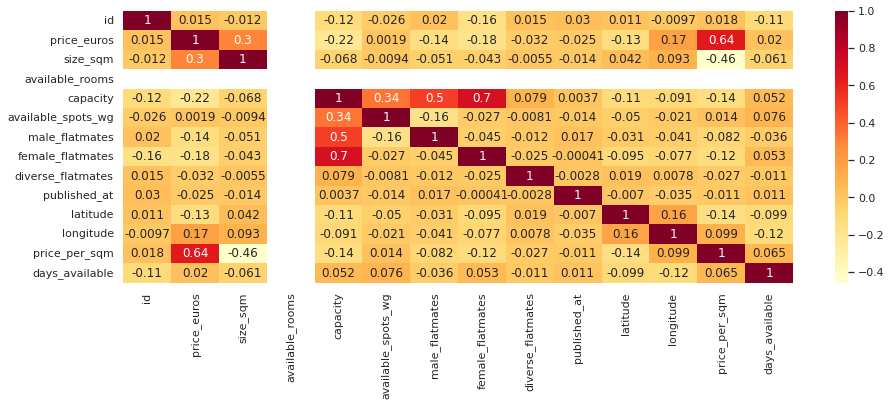

In [11]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

sns.heatmap(wg_df.corr(), cmap='YlOrRd', 
            annot = True, 
            annot_kws={"size": 12});

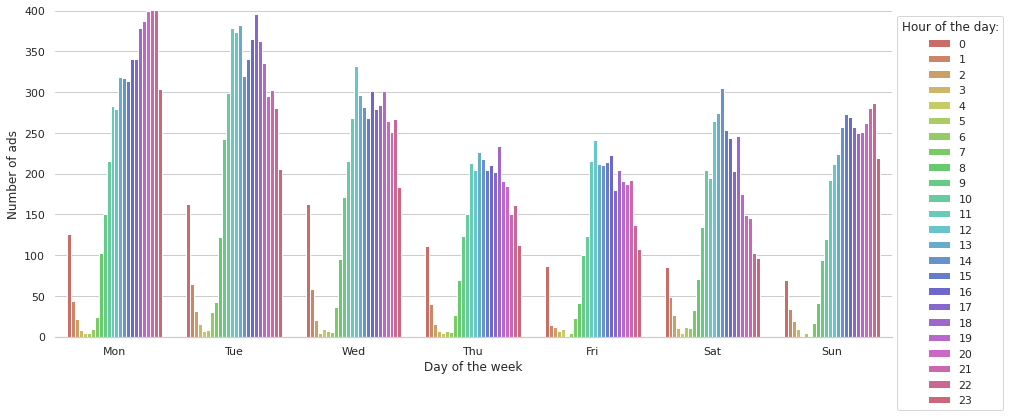

In [12]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax = plt.subplots(figsize=(15,6))

sns.countplot(
    data=wg_df[['day_of_week_publication','published_at']].dropna(axis=0),
    x="day_of_week_publication",
    hue = 'published_at',
    order=['Mon', 'Tue', 'Wed', "Thu", "Fri", "Sat", "Sun"],
    palette='hls', # or husl are exampels of circular color palletes
    ax=ax)
plt.legend(bbox_to_anchor = (1, 1), title = 'Hour of the day:')
sns.despine(top=True,left=True,right=True) # Background grid borders
ax.set(ylim=(0, 400), ylabel="Number of ads", xlabel="Day of the week");

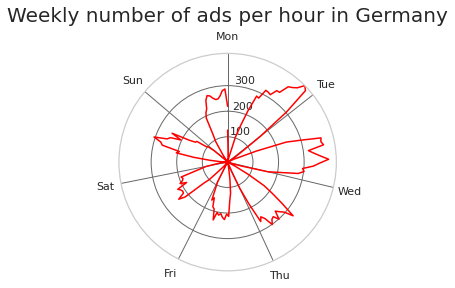

In [13]:
day_week_map = {'Mon':0,'Tue':1,'Wed':2,'Thu':3,'Fri':4,'Sat':5,'Sun':6}
foo = wg_df.copy()
foo['day_week_number'] = foo['day_of_week_publication'].map(day_week_map)
foo = foo.sort_values(by = ['day_week_number'], ascending=True)
foo['week_hour_publication'] = foo['day_week_number']*24 + foo['published_at'] 
foo = foo[['url','week_hour_publication']].dropna(axis=0).groupby(['week_hour_publication']).count().rename(columns = {'url':'count'}).reset_index()



plotting_values = [float(i)*np.pi/180.0 for i in list(np.arange(0, 361, 360/max(foo['week_hour_publication'])))]
mapping_dict = dict(zip(range(0,max(foo['week_hour_publication'])+1), plotting_values))
foo['week_hour_publication_radians'] = foo['week_hour_publication'].map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

ax = plt.subplot(111, projection='polar')


foo.plot(x='week_hour_publication_radians', y='count', color ='red', ax=ax)


ax.grid(True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


ax.xaxis.set_ticks(plotting_values[::24])
ax.set_xticklabels(days_of_week)
ax.set_xlabel('')

ax.set_rmax(400)
ax.set_rticks([100,200,300])
ax.set_rlabel_position(5)  # Rotate labels

ax.get_legend().remove()
#change colors of axis to gray
ax.xaxis.grid(True,color='dimgray',linestyle='-', linewidth = 1)
ax.yaxis.grid(True,color='dimgray',linestyle='-', linewidth = 1)

ax.set_title("Weekly number of ads per hour in Germany", va='bottom', fontsize=20)
ax.margins(0)
plt.show()

''

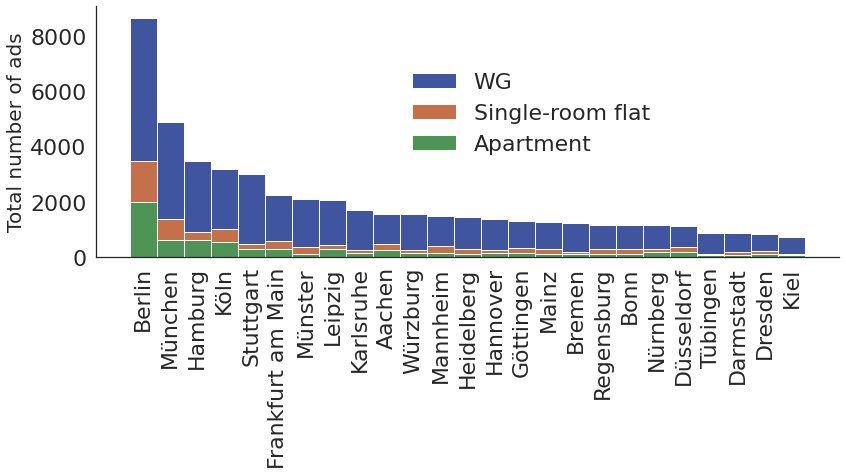

In [14]:
city_ads_df = ads_df[['url', 'city']].groupby('city').count().sort_values(by = ['url'], ascending=False)
reorderlist = list(city_ads_df.index)
ads_df_ordered_counts = ads_df.iloc[pd.Categorical(ads_df.city,reorderlist).argsort()]


sns.set_theme(style = "white", font_scale= 2)
ax = sns.displot(x='city', data=ads_df_ordered_counts, hue='type_offer_simple',
            hue_order=['WG', 'Single-room flat','Apartment'],
            multiple='stack',
            height=5, aspect=10/4,
            palette='dark',
           )

# ax.set(ylim=(0, 8000));
ax.set_xticklabels(rotation = 90)
ax.set_ylabels(label="Total number of ads", fontsize=20) # not set_label
ax.set_xlabels('', fontsize=20) # not set_label
hue_labels=['WG', 'Single-room flat','Multi']

sns.move_legend(ax, loc = "upper right", bbox_to_anchor= (0.6,0.8), title = '')
;

In [15]:
sns.boxenplot(data = wg_df, y = 'city', x = 'price_euros',
            order = city_wg_df.index,
            palette='crest',
            ax=ax2)

<AxesSubplot:title={'center':'Single-room flat'}, xlabel='price_euros', ylabel='city'>

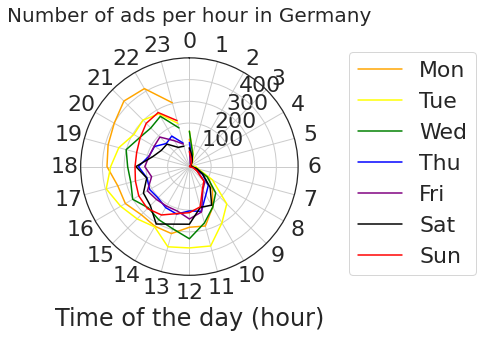

In [16]:
wg_df_time = wg_df[['url', 'day_of_week_publication','published_at']].groupby(['day_of_week_publication','published_at']).count().rename(columns = {'url':'count'}).reset_index()

plotting_values = [float(i)*np.pi/180.0 for i in list(np.arange(0, 360, 360/24))]
mapping_dict = dict(zip(range(0,24), plotting_values))
wg_df_time['published_at_radians'] = wg_df_time.published_at.map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

ax = plt.subplot(111, projection='polar')

for day_i in range(7):
    # Filter day week
    foo = wg_df_time[wg_df_time['day_of_week_publication'] == days_of_week[day_i]]
    foo.plot('published_at_radians', 'count', color = colors[day_i], label = days_of_week[day_i], ax=ax)


ax.grid(True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


ax.xaxis.set_ticks(plotting_values)
ax.set_xticklabels(np.arange(0, 24, 1))
ax.set_xlabel('Time of the day (hour)')

ax.set_rmax(500)
ax.set_rticks([100,200,300,400])
ax.set_rlabel_position(35)  # Rotate labels

# Legend positioning
angle = np.deg2rad(-30)
ax.legend(loc="lower left",
          bbox_to_anchor=(0.75 + np.cos(angle)/2, # Horizontal distance from center
                          .2 + np.sin(angle)/2)) # Vertical distance from center

ax.set_title("Number of ads per hour in Germany", va='bottom', fontsize=20)
plt.show()

''

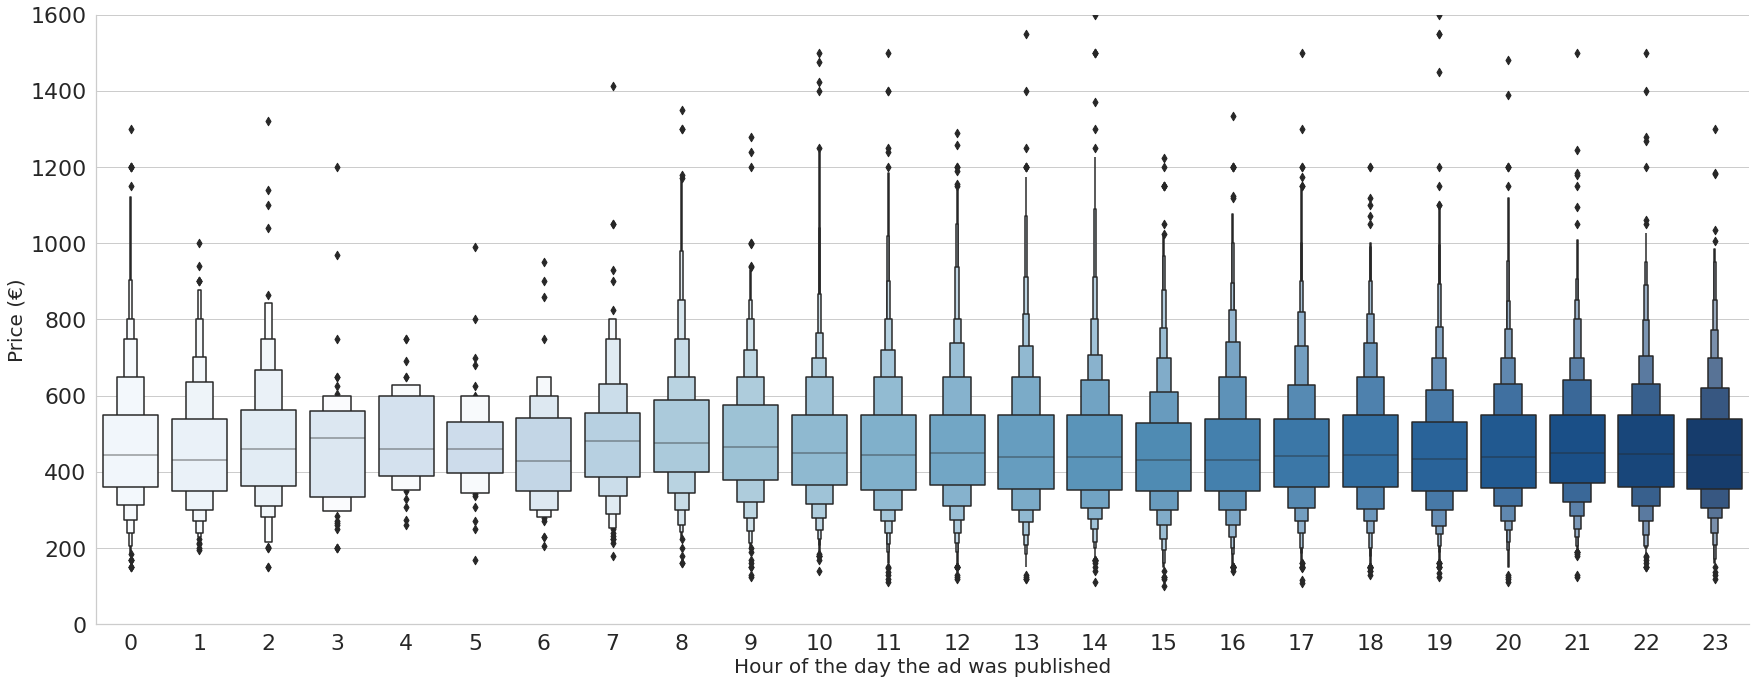

In [17]:
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = wg_df[['published_at','price_euros']].dropna(axis=0), 
                 x = 'published_at', y = 'price_euros',
                 kind='boxen',
                 palette='Blues',
                 height=10, aspect=10/4)
ax.set(ylim=(0, 1600))
ax.set_ylabels(label="Price (€)", fontsize=20) # not set_label
ax.set_xlabels('Hour of the day the ad was published', fontsize=20) # not set_label
;

''

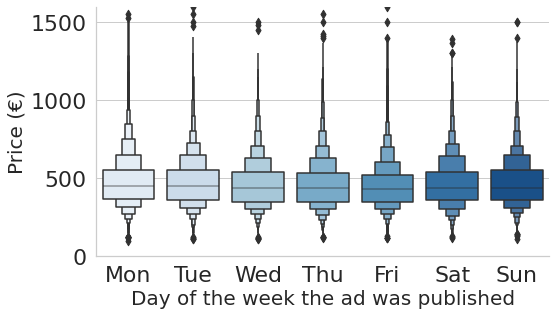

In [18]:
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = wg_df, 
                 x = 'day_of_week_publication', y = 'price_euros',
                 order=['Mon', 'Tue', 'Wed', "Thu", "Fri", "Sat", "Sun"],
                 kind='boxen',
                 palette='Blues',
                 height=5, aspect=10/6)
ax.set(ylim=(0, 1600))
ax.set_ylabels(label="Price (€)", fontsize=20) # not set_label
ax.set_xlabels('Day of the week the ad was published', fontsize=20) # not set_label
;

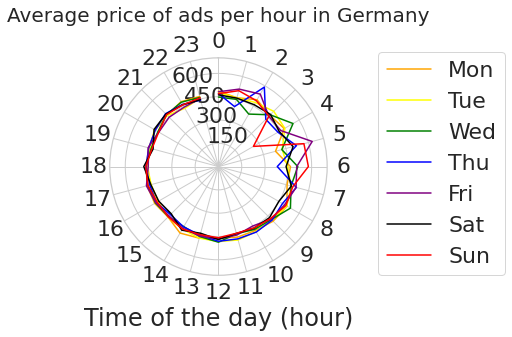

In [19]:
wg_df_time = wg_df[['price_euros', 'day_of_week_publication','published_at']].groupby(['day_of_week_publication','published_at']).mean().reset_index()

plotting_values = [float(i)*np.pi/180.0 for i in list(np.arange(0, 360, 360/24))]
mapping_dict = dict(zip(range(0,24), plotting_values))
wg_df_time['published_at_radians'] = wg_df_time.published_at.map(mapping_dict)

colors = ['orange', 'yellow', 'green', 'blue', 'purple', 'black', 'red']
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


sns.set_theme(style = "whitegrid", font_scale= 2)
ax = plt.subplot(111, projection='polar')

for day_i in range(7):
    # Filter day week
    foo = wg_df_time[wg_df_time['day_of_week_publication'] == days_of_week[day_i]]
    foo.plot('published_at_radians', 'price_euros', color = colors[day_i], label = days_of_week[day_i], ax=ax)


ax.grid(True)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)


ax.xaxis.set_ticks(plotting_values)
ax.set_xticklabels(np.arange(0, 24, 1))
ax.set_xlabel('Time of the day (hour)')

ax.set_rmax(700)
ax.set_rticks([150,300,450,600])  # Move radial labels away from plotted line
ax.set_rlabel_position(-30)  # Rotate labels

# Legend positioning
angle = np.deg2rad(-30)
ax.legend(loc="lower left",
          bbox_to_anchor=(0.75 + np.cos(angle)/2, # Horizontal distance from center
                          .2 + np.sin(angle)/2)) # Vertical distance from center

ax.set_title("Average price of ads per hour in Germany", va='bottom', fontsize=20)
plt.show()

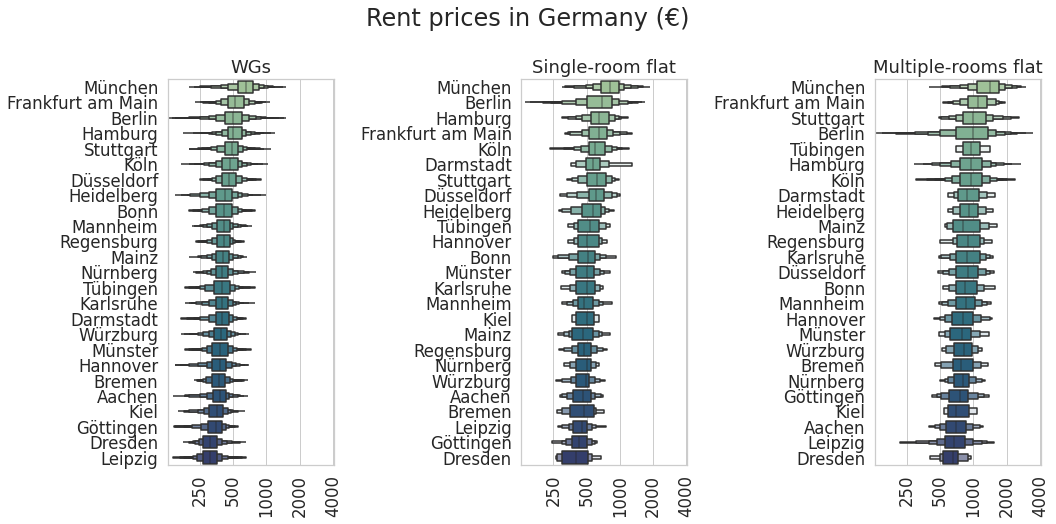

In [20]:
# Finding the order
city_wg_df = wg_df[['price_euros', 'city']].groupby('city').mean().sort_values(by = ['price_euros'], ascending=False)
city_singleroom_df = singleroom_df[['price_euros', 'city']].groupby('city').mean().sort_values(by = ['price_euros'], ascending=False)
city_flathouse_df = flathouse_df[['price_euros', 'city']].groupby('city').mean().sort_values(by = ['price_euros'], ascending=False)

# Log transform prices
wg_df_mod = wg_df.copy()
wg_df_mod['price_euros'] = np.log2(wg_df_mod['price_euros'])

singleroom_df_mod = singleroom_df.copy()
singleroom_df_mod['price_euros'] = np.log2(singleroom_df_mod['price_euros'])

flathouse_df_mod = flathouse_df.copy()
flathouse_df_mod['price_euros'] = np.log2(flathouse_df_mod['price_euros'])

# Figure
sns.set_theme(style = "whitegrid", font_scale= 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 7.5))

sns.boxenplot(data = wg_df_mod, y = 'city', x = 'price_euros',
            order = city_wg_df.index,
            palette='crest', showfliers = False,
            ax=ax1).set(title='WGs')

sns.boxenplot(data = singleroom_df_mod, y = 'city', x = 'price_euros',
            order = city_singleroom_df.index,
            palette='crest', showfliers = False,
            ax=ax2).set(title='Single-room flat')

sns.boxenplot(data = flathouse_df_mod, y = 'city', x = 'price_euros',
            order = city_flathouse_df.index,
            palette='crest', showfliers = False,
            ax=ax3).set(title='Multiple-rooms flat')

ax1.set(xlim=(7, 12), xlabel=None, ylabel=None)
ax1.set_xticks([np.log2(250),np.log2(500),np.log2(1000),np.log2(2000),np.log2(4000)])
ax1.set_xticklabels(rotation = 90, labels =[250,500,1000,2000,4000])


ax2.set(xlim=(7, 12), xlabel=None, ylabel=None)
ax2.set_xticks([np.log2(250),np.log2(500),np.log2(1000),np.log2(2000),np.log2(4000)])
ax2.set_xticklabels(rotation = 90, labels =[250,500,1000,2000,4000])

ax3.set(xlim=(7, 12), xlabel=None, ylabel=None)
ax3.set_xticks([np.log2(250),np.log2(500),np.log2(1000),np.log2(2000),np.log2(4000)])
ax3.set_xticklabels(rotation = 90, labels =[250,500,1000,2000,4000])
fig.suptitle('Rent prices in Germany (€)', fontsize=24)

plt.tight_layout();

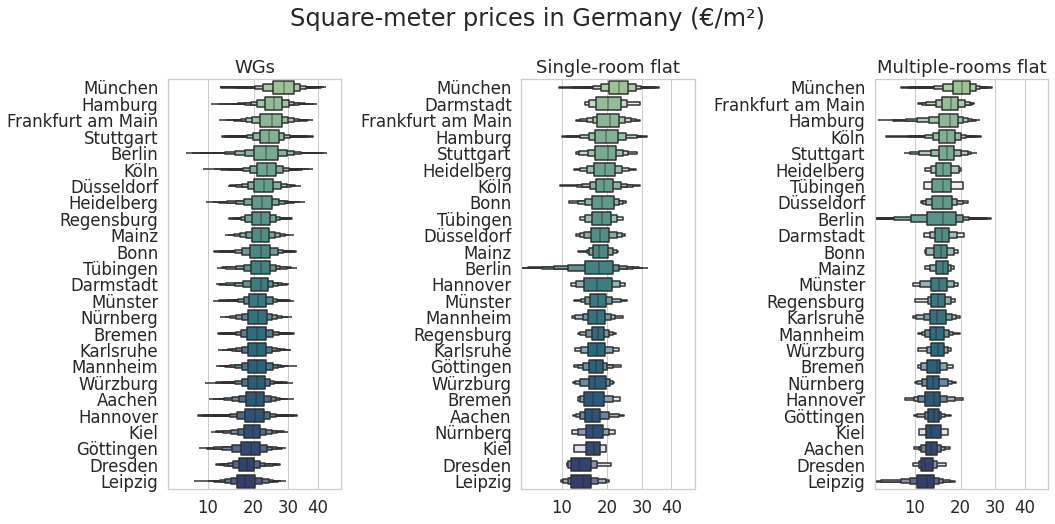

In [21]:
# Finding the order
city_wg_df = wg_df[['price_per_sqm', 'city']].groupby('city').mean().sort_values(by = ['price_per_sqm'], ascending=False)
city_singleroom_df = singleroom_df[['price_per_sqm', 'city']].groupby('city').mean().sort_values(by = ['price_per_sqm'], ascending=False)
city_flathouse_df = flathouse_df[['price_per_sqm', 'city']].groupby('city').mean().sort_values(by = ['price_per_sqm'], ascending=False)

# Log transform prices
wg_df_mod = wg_df.copy()
wg_df_mod['price_per_sqm'] = np.log2(wg_df_mod['price_per_sqm'])

singleroom_df_mod = singleroom_df.copy()
singleroom_df_mod['price_per_sqm'] = np.log2(singleroom_df_mod['price_per_sqm'])

flathouse_df_mod = flathouse_df.copy()
flathouse_df_mod['price_per_sqm'] = np.log2(flathouse_df_mod['price_per_sqm'])

# Figure
sns.set_theme(style = "whitegrid", font_scale= 1.5)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 7.5))

sns.boxenplot(data = wg_df_mod, y = 'city', x = 'price_per_sqm',
            order = city_wg_df.index,
            palette='crest', showfliers = False,
            ax=ax1).set(title='WGs')

sns.boxenplot(data = singleroom_df_mod, y = 'city', x = 'price_per_sqm',
            order = city_singleroom_df.index,
            palette='crest', showfliers = False,
            ax=ax2).set(title='Single-room flat')

sns.boxenplot(data = flathouse_df_mod, y = 'city', x = 'price_per_sqm',
            order = city_flathouse_df.index,
            palette='crest', showfliers = False,
            ax=ax3).set(title='Multiple-rooms flat')

ax1.set(xlim=(2, 7), xlabel="", ylabel="")
ax1.set_xticks([10**0.5,20**0.5,30**0.5,40**0.5], [10,20,30,40])

ax2.set(xlim=(2, 7), xlabel="", ylabel="")
ax2.set_xticks([10**0.5,20**0.5,30**0.5,40**0.5], [10,20,30,40])

ax3.set(xlim=(2, 7), xlabel="", ylabel="")
ax3.set_xticks([10**0.5,20**0.5,30**0.5,40**0.5], [10,20,30,40])
fig.suptitle('Square-meter prices in Germany (€/m²)', fontsize=24)

plt.tight_layout();

''

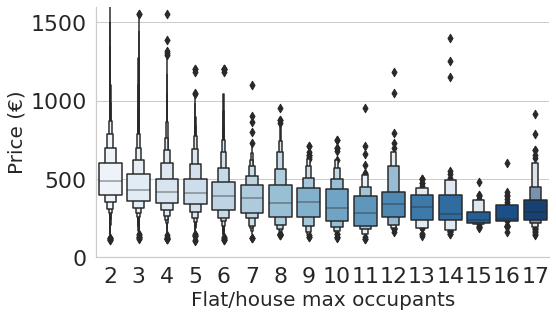

In [22]:
sns.set_theme(style = "whitegrid", font_scale= 2)
ax = sns.catplot(data = wg_df, 
                 x = 'capacity', y = 'price_euros',
                 kind='boxen',
                 palette='Blues',
                 height=5, aspect=10/6)
ax.set(ylim=(0, 1600))
ax.set_ylabels(label="Price (€)", fontsize=20) # not set_label
ax.set_xlabels('Flat/house max occupants', fontsize=20) # not set_label
;

In [23]:
def create_ridgeline_plot(df = wg_df,
                          column = 'price_euros',
                          factor = 'city',
                          max_x = 1200, min_x = 0,
                          max_y = 0.008, min_y = 0,
                          pal_name = 'crest',
                         title = 'WG rent in Germany,\n rent (€)', unit='€'):
    
    foo_df = df[[column, factor]].groupby(by=factor).mean().sort_values(by = column, ascending=False).reset_index().copy()
    ordered_factors = foo_df[factor].tolist()
    mapping_dict = dict(zip(ordered_factors, range(1,len(ordered_factors)+1,1)))
    # Map city order for plotting
    df['order_factors'] = df[factor].map(mapping_dict)

    # Limit prices for the plot
    df = df[df[column] <= max_x]
    df = df[df[column] >= min_x]

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})  

    # we generate a color palette with Seaborn.color_palette()
    pal = sns.color_palette(palette=pal_name, n_colors=len(ordered_factors))  

    # in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette'
    g = sns.FacetGrid(df, row='order_factors', hue='order_factors', aspect=10, height=1, palette=pal)

    # then we add the densities kdeplots for each city
    g.map(sns.kdeplot, column,
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5)

    # here we add a white line that represents the contour of each kdeplot
    g.map(sns.kdeplot, column, 
          bw_adjust=1, clip_on=False, 
          color="w", lw=3)

    # here we add a horizontal line for each plot
    g.map(plt.axhline, y=0,
          lw=0.25, clip_on=False)

    # we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
    # notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
    for i, ax in enumerate(g.axes.flat):
        factor_name = list(mapping_dict.keys())[i]
        mean_value = round(float(foo_df[foo_df[factor] == factor_name][column]),2)
        
        ax.text(-(max_x+abs(min_x))/5, max_y/10, # Text location
                f'{factor_name}\nmean = {mean_value} {unit}', # Text label
                fontsize=15,
                color=ax.lines[-1].get_color()) # Text color

    # we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
    g.fig.subplots_adjust(hspace=-0.75)

    # eventually we remove axes titles, yticks and spines
    g.set_titles("")
    g.set(ylabel = '', yticks=[], ylim = (min_y,max_y), xlim = (-(max_x+abs(min_x))/5, max_x))
    g.despine(bottom=True, left=True)

    plt.setp(ax.get_xticklabels(), fontsize=20)
    plt.xlabel('', fontsize=20)
    plt.ylabel('')
    g.fig.suptitle(title,
                   ha='center',
                   fontsize=20,
                   fontweight=20);
    
    return g

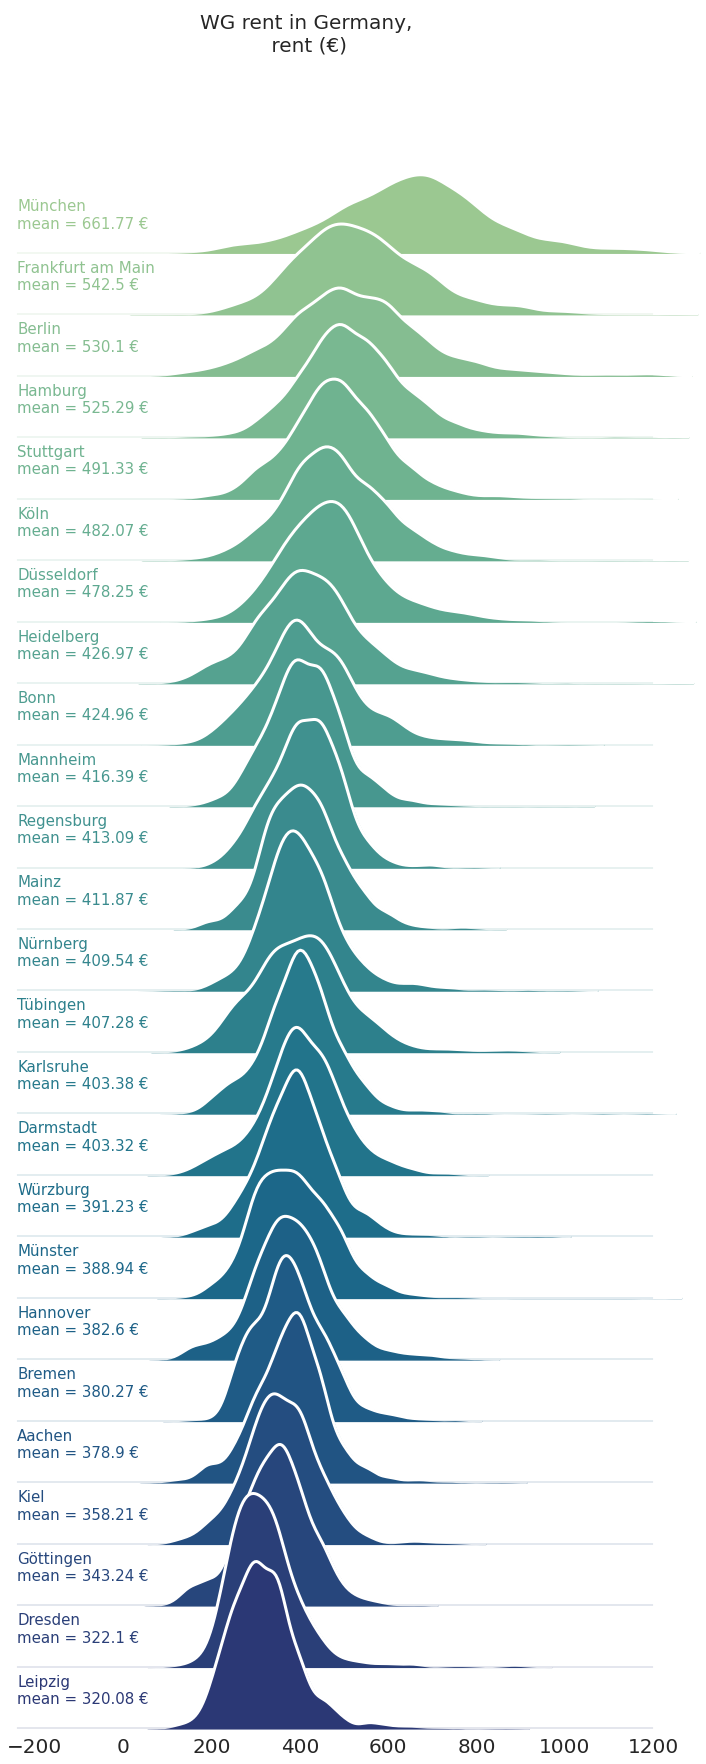

In [24]:
create_ridgeline_plot(df = wg_df,
                          column = 'price_euros',
                          factor = 'city',
                          max_x = 1200, min_x = 0,
                          max_y = 0.008, min_y = 0,
                          pal_name = 'crest',
                         title = 'WG rent in Germany,\n rent (€)');

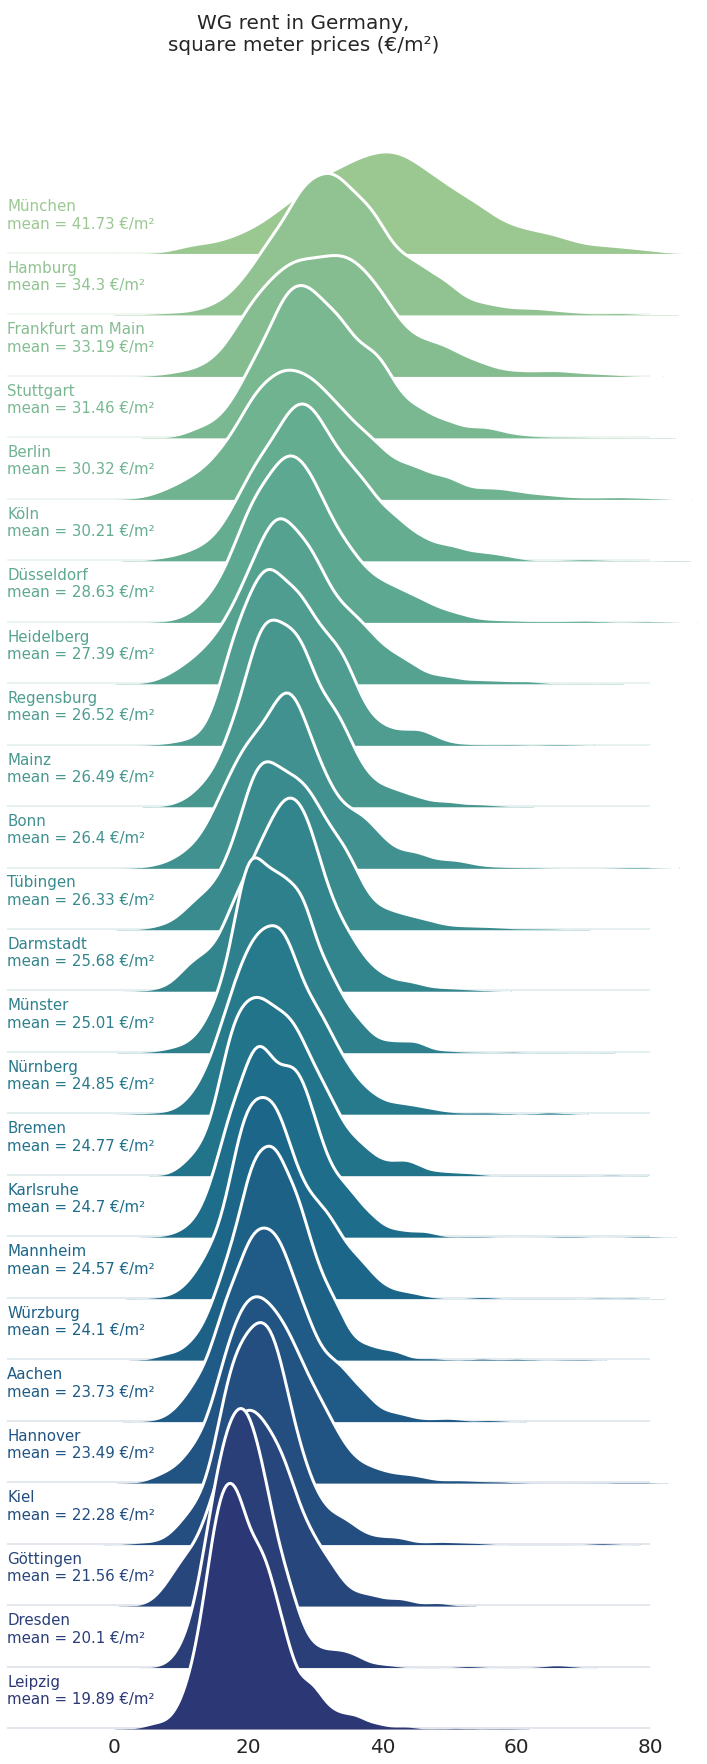

In [25]:
create_ridgeline_plot(df = wg_df,
                          column = 'price_per_sqm',
                          factor = 'city',
                          max_x = 80, min_x = 0,
                          max_y = 0.08, min_y = 0,
                          pal_name = 'crest',
                         title = 'WG rent in Germany,\nsquare meter prices (€/m²)', unit = '€/m²');

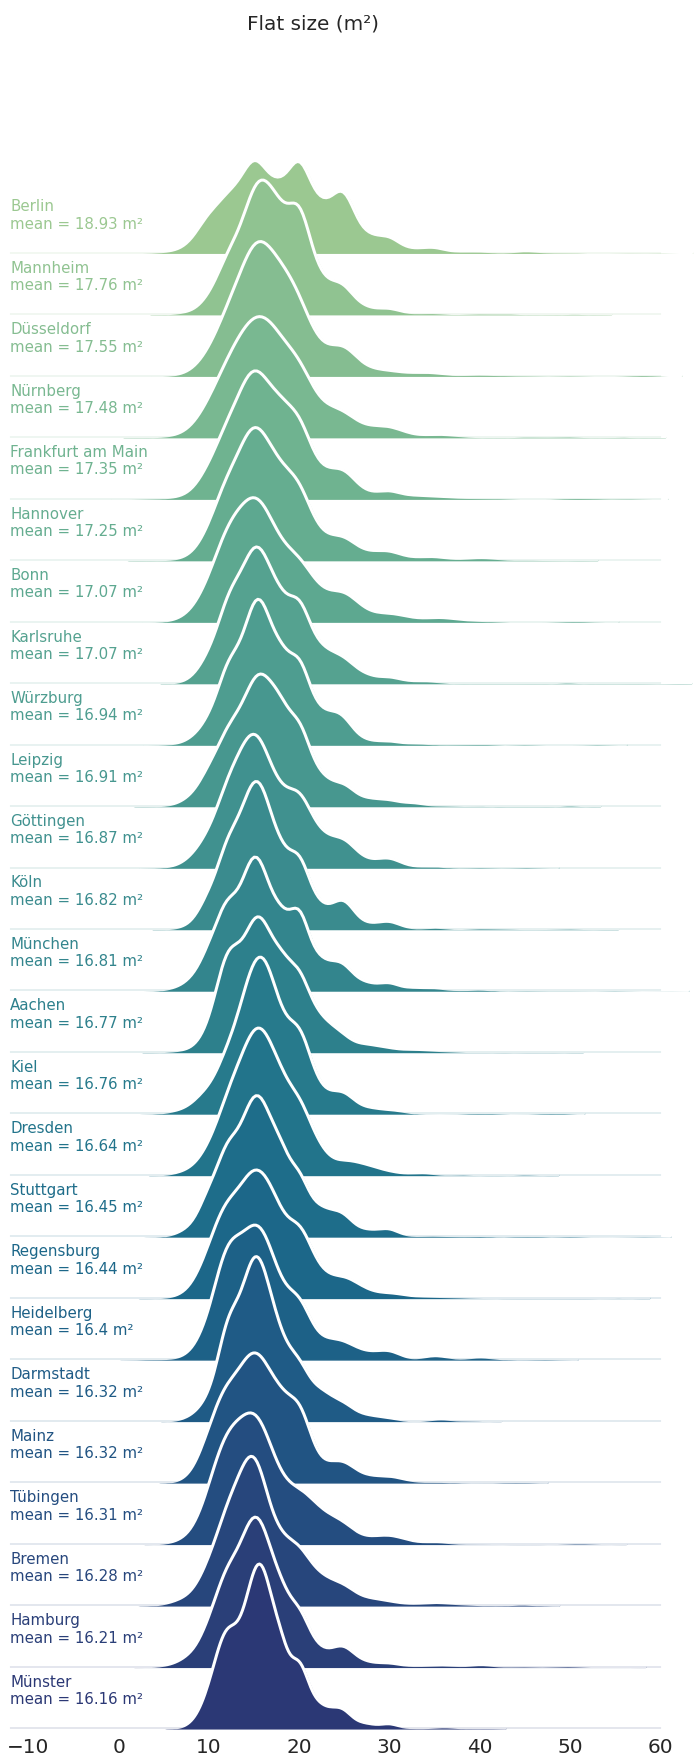

In [26]:
create_ridgeline_plot(df = wg_df,
                          column = 'size_sqm',
                          factor = 'city',
                          max_x = 60, min_x = 0,
                          max_y = 0.182, min_y = 0,
                          pal_name = 'crest',
                         title = 'Flat size (m²)', unit = 'm²');

sns.pairplot(iris, hue="species", palette="Set2", diag_kind="kde", height=2.5)

In [27]:
# Generate tables for plotting
ads_df_grouped = ads_df[['price_per_sqm', 'city', 'type_offer_simple']].groupby(['city','type_offer_simple']).mean().reset_index()
ads_df_grouped = ads_df_grouped.pivot(index='city', columns = 'type_offer_simple', values='price_per_sqm').reset_index()
ads_df_grouped.head()

type_offer_simple       city  Apartment      House  Single-room flat  \
0                     Aachen  12.869492  25.410000         17.489095   
1                     Berlin  15.646768  20.262727         19.131191   
2                       Bonn  15.501789  20.343333         20.931200   
3                     Bremen  13.853708  16.845000         18.132527   
4                  Darmstadt  15.893103  17.730000         24.158961   

type_offer_simple         WG  
0                  23.673199  
1                  30.265329  
2                  26.356483  
3                  24.734446  
4                  25.652629

In [28]:
from plotly.subplots import make_subplots
# import plotly.graph_objects as go

fig = make_subplots(
    rows=1, cols=3)#,
#     subplot_titles=("WG X multi-room flat", "WG X Single-room flat", "multi-room flat X Single-room flat"))

ax1= px.scatter(data_frame = ads_df_grouped, y='Apartment',x='WG', color = 'city')
for index in range(len(ax1['data'])):
    fig.add_trace(ax1['data'][index],
                  row=1, col=1)

ax2= px.scatter(data_frame = ads_df_grouped, y='Single-room flat',x='WG', color = 'city')
for index in range(len(ax2['data'])):
    fig.add_trace(ax2['data'][index],
                  row=1, col=2)

ax3= px.scatter(data_frame = ads_df_grouped, y='Single-room flat',x='Apartment', color = 'city')
for index in range(len(ax3['data'])):
    fig.add_trace(ax3['data'][index],
                  row=1, col=3)

fig.update_layout(height=400, width=1000,
                  title_text="Average square-meter prices in Germany (€/m²)", showlegend=False)

# Update xaxis properties
fig.update_xaxes(title_text="WGs", range=[15, 45], row=1, col=1)
fig.update_xaxes(title_text="WGs", range=[15, 45], row=1, col=2)
fig.update_xaxes(title_text="Multi-room flats", range=[10, 25], row=1, col=3)

# Update yaxis properties
fig.update_yaxes(title_text="Single-room flats", range=[10, 25], row=1, col=1)
fig.update_yaxes(title_text="Multi-room flats", range=[10, 35], row=1, col=2)
fig.update_yaxes(title_text="Single-room flats", range=[10, 35], row=1, col=3)


fig.show()